# Get started with your EDA

## imports

In [1]:
import pandas as pd
from os import path
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

from utils.load_data import read_online_proms_data, downcast, structure_name, get_meta, clean_data
from utils.data_dictionary import methods

ModuleNotFoundError: No module named 'utils.load_data'

In [ ]:
# from https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/patient-reported-outcome-measures-proms
URL_PROMS_DATA = [
    r"https://files.digital.nhs.uk/6C/A1D581/CSV%20Data%20Pack%202016-17%20Finalised.zip",
    r"https://files.digital.nhs.uk/70/5176AA/CSV%20Data%20Pack%20Final%201718.zip",
    r"https://files.digital.nhs.uk/52/A8FF7F/PROMs%20CSV%20Data%20Pack%20Finalised%202018-19.zip",
    r"https://files.digital.nhs.uk/1F/51FEDE/PROMs%20CSV%20Data%20Pack%20Provisional%201920.zip",
]

DATA_PATH = "../data"

PART = "knee"
ORG = "provider"

## load data

In [2]:
%%time

# define path location
file_name = f"{PART}-{ORG}.parquet"
full_path = path.join(DATA_PATH, file_name)

# load from disk if present,
# otherwise get it directly from NHS-source + rename columns + save to parquet
if path.isfile(full_path):
    df_raw = pd.read_parquet(full_path)
else:
    df_raw = read_online_proms_data(urls=URL_PROMS_DATA, part=PART, org=ORG).apply(downcast)
    df_raw.columns = (
        df_raw.columns.str.replace("Pre-Op Q", "t0")
        .str.replace("Post-Op Q", "t1")
        .str.replace("Knee Replacement", "oks")
        .str.replace("Hip Replacement", "ohs")
        .str.replace("-", "_")
        .str.replace(" ", "_")
        .str.lower()
    )
    df_raw.to_parquet(full_path)

# display basic info df_raw    
df_raw.info(verbose=False)

NameError: name 'PART' is not defined

## basic cleaning

In [4]:
%%time
# restructure names
df_raw.columns = [structure_name(col) for col in df_raw.columns]

# construct a meta data df
df_meta = get_meta(df_raw.columns)  

# clean the data based on meta (all not in range, labels or label "missing")
df_clean = clean_data(df_raw, df_meta).apply(downcast)

# raise warning if somewhere there is a hidden 9 as max
if (df_clean.describe(include="all").loc["max"]==9).any():
    to_check = list(df_clean.loc[:, df_clean.describe(include="all").loc["max"]==9].columns)
    warning.warn("Please check the folowing columns for meta data:")
    display(to_check)
    
df_clean.sample(3)

CPU times: user 3.32 s, sys: 2.88 s, total: 6.2 s
Wall time: 6.25 s


,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
19401,RCX,Knee Replacement,0.0,2017/18,60 to 69,1.0,2.0,NaN,4.0,2.0,...,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,35.0,34.515030
3077,ADP02,Knee Replacement,0.0,2017/18,70 to 79,1.0,1.0,NaN,2.0,1.0,...,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,44.0,42.784508
16466,RAJ,Knee Replacement,0.0,2017/18,60 to 69,2.0,2.0,NaN,2.0,2.0,...,4.0,4.0,3.0,2.0,3.0,3.0,4.0,4.0,42.0,34.951996


### drop revisions and last year of data

In [5]:
df_eda = df_clean.query("t0_revision_flag == 0 & t0_year != '2019/20'")\
                 .drop(columns="t0_revision_flag")
df_eda["t0_year"].unique()

['2016/17', '2017/18', '2018/19']
Categories (3, object): ['2016/17', '2017/18', '2018/19']

## simple descriptives

In [6]:
df_eda.describe(include="all")

,t0_provider_code,t0_procedure,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
count,133962,133962,133962,124839,124839.000000,132505.000000,0.0,132834.000000,132976.000000,131963.000000,...,132753.000000,133005.000000,132918.000000,132913.000000,132994.000000,133061.000000,132996.000000,133023.000000,131505.000000,128931.000000
unique,294,1,3,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,RL1,Knee Replacement,2016/17,70 to 79,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2836,133962,45810,52964,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.572169,1.845742,NaN,2.598378,1.956451,1.234695,...,3.360482,3.100387,3.102417,1.619653,3.071259,3.511825,3.190480,3.042842,36.139114,34.673512
std,NaN,NaN,NaN,NaN,0.494966,0.360955,NaN,0.866529,0.204197,0.450179,...,0.986961,0.886706,1.078495,1.336825,0.981731,0.818700,1.177223,1.018227,9.304650,4.464665
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.453117
25%,NaN,NaN,NaN,NaN,1.000000,2.000000,NaN,2.000000,2.000000,1.000000,...,3.000000,3.000000,3.000000,0.000000,2.000000,3.000000,3.000000,2.000000,31.000000,31.839390
50%,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,2.000000,2.000000,1.000000,...,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,4.000000,3.000000,38.000000,35.221458
75%,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,3.000000,2.000000,1.000000,...,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,44.000000,38.079254


In [7]:
df_eda.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133962 entries, 0 to 45634
Columns: 80 entries, t0_provider_code to t1_oks_predicted
dtypes: category(4), float32(76)
memory usage: 40.5 MB


In [8]:
display(df_eda)

,t0_provider_code,t0_procedure,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
0,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,4.0,2.0,2.0,...,2.0,2.0,3.0,2.0,3.0,1.0,3.0,2.0,29.0,28.123755
1,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,1.0,2.0,2.0,...,4.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,39.0,39.592751
2,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,2.0,2.0,1.0,...,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,45.0,40.250790
3,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,2.0,2.0,1.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,43.0,37.896225
4,ADP02,Knee Replacement,2016/17,NaN,NaN,1.0,NaN,3.0,2.0,1.0,...,3.0,4.0,2.0,2.0,2.0,4.0,2.0,3.0,36.0,40.142567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45630,RYR,Knee Replacement,2018/19,80 to 89,2.0,2.0,NaN,2.0,2.0,1.0,...,2.0,3.0,3.0,1.0,3.0,4.0,2.0,4.0,33.0,36.247471
45631,RYR,Knee Replacement,2018/19,80 to 89,2.0,1.0,NaN,1.0,2.0,2.0,...,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,38.0,37.609413
45632,RYR,Knee Replacement,2018/19,80 to 89,2.0,2.0,NaN,2.0,2.0,1.0,...,3.0,3.0,3.0,0.0,3.0,3.0,4.0,4.0,34.0,35.843468
45633,RYR,Knee Replacement,2018/19,80 to 89,2.0,2.0,NaN,2.0,2.0,1.0,...,4.0,3.0,4.0,1.0,3.0,4.0,4.0,4.0,38.0,37.130714


In [9]:
# Only Knee-replacements in df(?)
df_eda["t0_procedure"].value_counts()

Knee Replacement    133962
Name: t0_procedure, dtype: int64

In [10]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133962 entries, 0 to 45634
Data columns (total 80 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   t0_provider_code        133962 non-null  category
 1   t0_procedure            133962 non-null  category
 2   t0_year                 133962 non-null  category
 3   t0_age_band             124839 non-null  category
 4   t0_gender               124839 non-null  float32 
 5   t0_assisted             132505 non-null  float32 
 6   t0_assisted_by          0 non-null       float32 
 7   t0_symptom_period       132834 non-null  float32 
 8   t0_previous_surgery     132976 non-null  float32 
 9   t0_living_arrangements  131963 non-null  float32 
 10  t0_disability           128293 non-null  float32 
 11  t0_heart_disease        12463 non-null   float32 
 12  t0_high_bp              59267 non-null   float32 
 13  t0_stroke               2221 non-null    float32 
 14  t0_ci

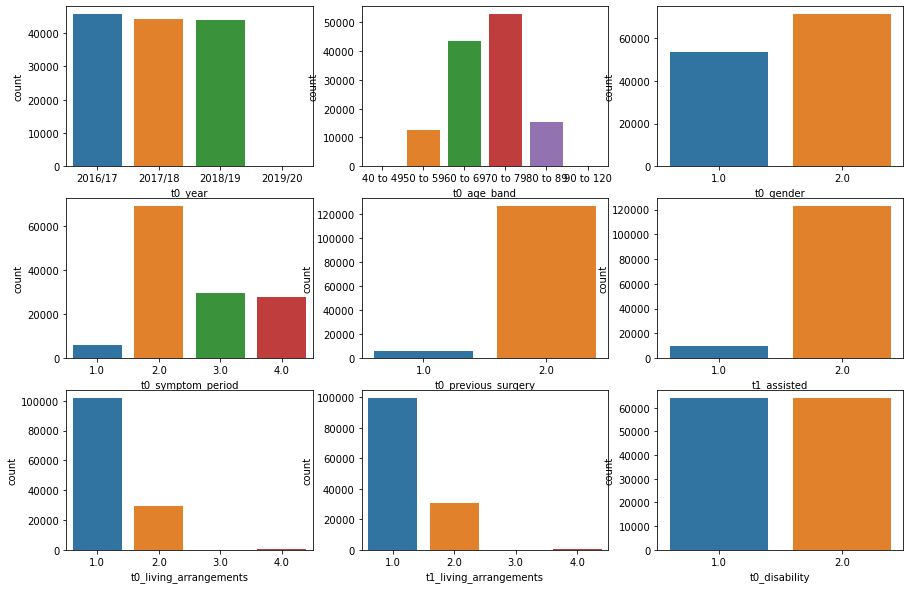

In [11]:
# 
fig, ax = plt.subplots(3, 3, figsize=(15,10))
ax =ax.flatten()
sns.countplot(x=df_eda["t0_year"], ax=ax[0])
sns.countplot(x=df_eda["t0_age_band"], ax=ax[1])
sns.countplot(x=df_eda["t0_gender"], ax=ax[2])
sns.countplot(x=df_eda["t0_symptom_period"], ax=ax[3])
sns.countplot(x=df_eda["t0_previous_surgery"], ax=ax[4])
sns.countplot(x=df_eda["t1_assisted"], ax=ax[5])
sns.countplot(x=df_eda["t0_living_arrangements"], ax=ax[6])
sns.countplot(x=df_eda["t1_living_arrangements"], ax=ax[7])
sns.countplot(x=df_eda["t0_disability"], ax=ax[8]);

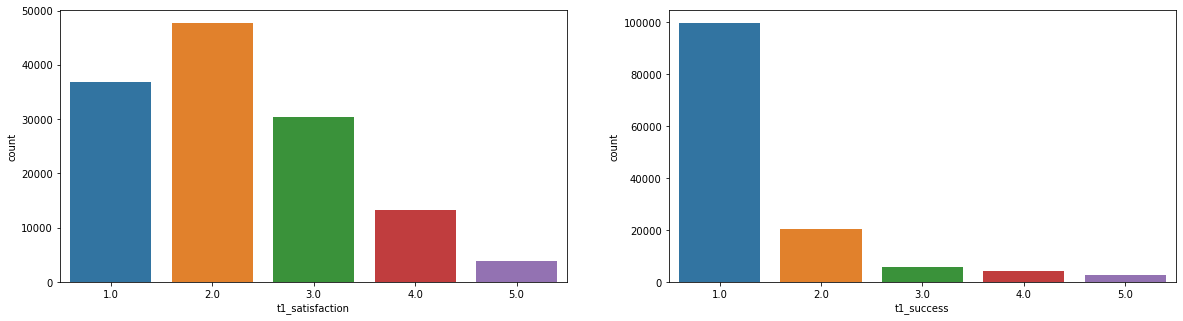

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x=df_eda["t1_satisfaction"], ax=ax[0])
sns.countplot(x=df_eda["t1_success"], ax=ax[1]);

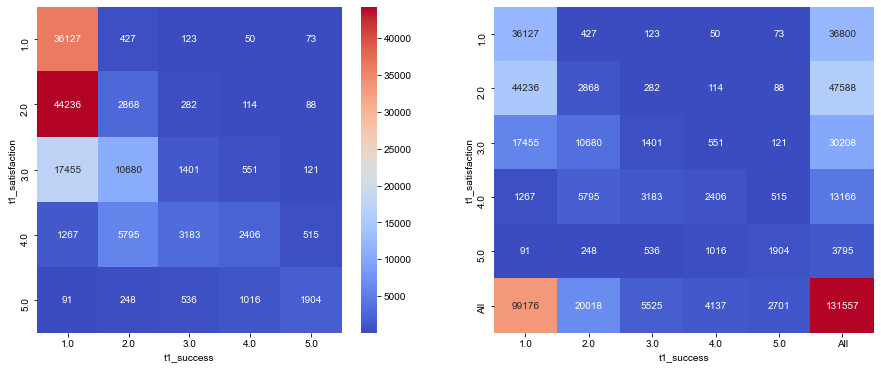

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(pd.crosstab([df_eda["t1_satisfaction"]], [df_eda["t1_success"]]), cmap="coolwarm", annot=True, cbar=True, fmt='g', ax=ax[0])
sns.heatmap(pd.crosstab([df_eda["t1_satisfaction"]], [df_eda["t1_success"]], margins=True), cmap='coolwarm', annot=True, fmt='g', cbar=False, ax=ax[1])
sns.set(font_scale=1.5)

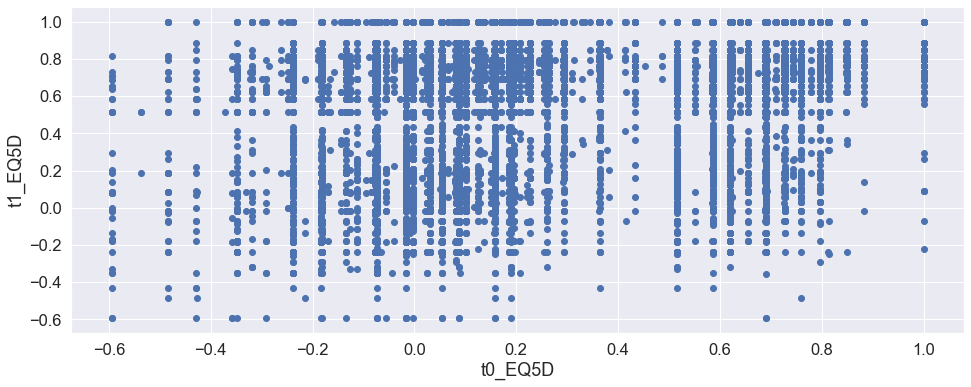

In [14]:
plt.figure(figsize=(16, 6))
plt.xlabel("t0_EQ5D")
plt.ylabel("t1_EQ5D")
plt.scatter(x=df_eda["t0_eq5d_score"], y=df_eda["t1_eq5d_score"], cmap='viridis');

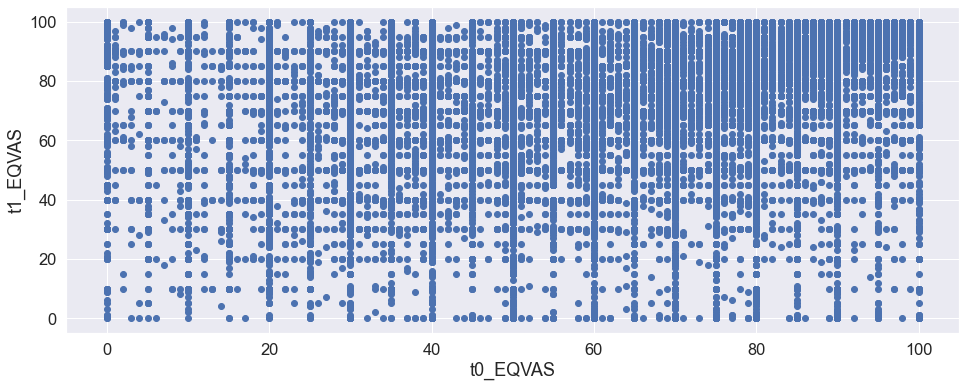

In [15]:
plt.figure(figsize=(16, 6))
plt.xlabel("t0_EQVAS")
plt.ylabel("t1_EQVAS")
plt.scatter(x=df_eda["t0_eqvas_score"], y=df_eda["t1_eqvas_score"], cmap='viridis');

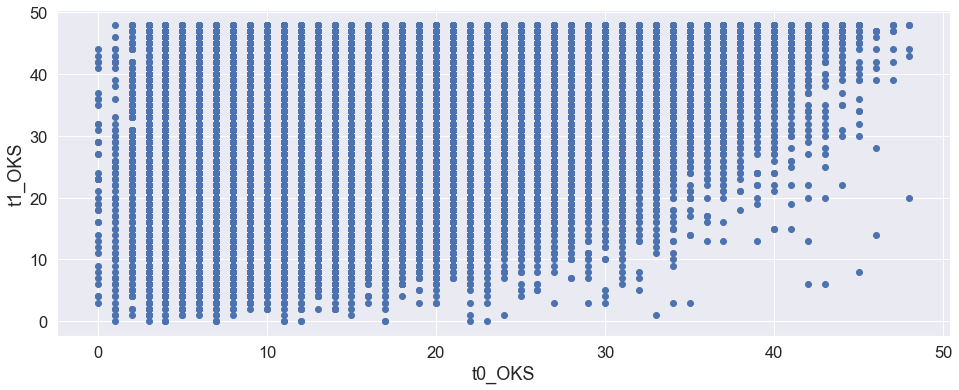

In [27]:
plt.figure(figsize=(16, 6))
plt.xlabel("t0_OKS")
plt.ylabel("t1_OKS")
plt.scatter(x=df_eda["t0_oks_score"], y=df_eda["t1_oks_score"], cmap='viridis');

In [16]:
df_eda["diff_eq5d_score"] = df_eda["t1_eq5d_score"] - df_eda["t0_eq5d_score"]
df_eda["diff_eqvas_score"] = df_eda["t1_eqvas_score"] - df_eda["t0_eqvas_score"]
df_eda["diff_OKS_score"] = df_eda["t1_oks_score"] - df_eda["t0_oks_score"]
df_eda.head(5)

,t0_provider_code,t0_procedure,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,...,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted,diff_eq5d_score,diff_eqvas_score,diff_OKS_score
0,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,4.0,2.0,2.0,...,2.0,3.0,1.0,3.0,2.0,29.0,28.123755,NaN,-13.0,14.0
1,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,1.0,2.0,2.0,...,2.0,4.0,4.0,4.0,3.0,39.0,39.592751,0.500,28.0,9.0
2,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,2.0,2.0,1.0,...,3.0,4.0,4.0,4.0,4.0,45.0,40.250790,0.899,15.0,21.0
3,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,2.0,2.0,1.0,...,4.0,4.0,4.0,4.0,4.0,43.0,37.896225,0.105,0.0,16.0
4,ADP02,Knee Replacement,2016/17,NaN,NaN,1.0,NaN,3.0,2.0,1.0,...,2.0,2.0,4.0,2.0,3.0,36.0,40.142567,0.000,NaN,4.0


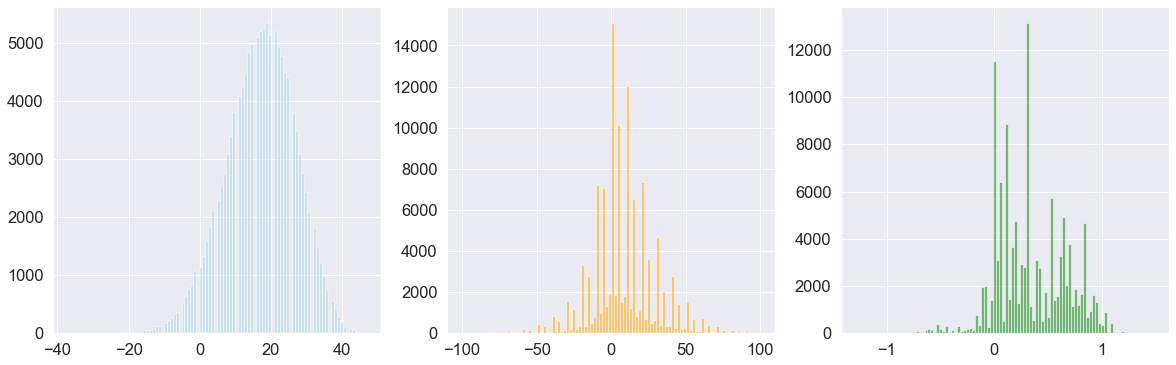

In [17]:
#Determine PROM outcome difference of QE5D, EQVAS and OKS
fig, ax =plt.subplots(1, 3, figsize=(20, 6))
ax[0].hist(x=df_eda["diff_OKS_score"], bins=100, alpha=0.5, color='lightblue')
ax[1].hist(x=df_eda["diff_eqvas_score"], bins=100, alpha=0.5, color='orange')
ax[2].hist(x=df_eda["diff_eq5d_score"], bins=100, alpha=0.5, color='green', label="qe5d_score");

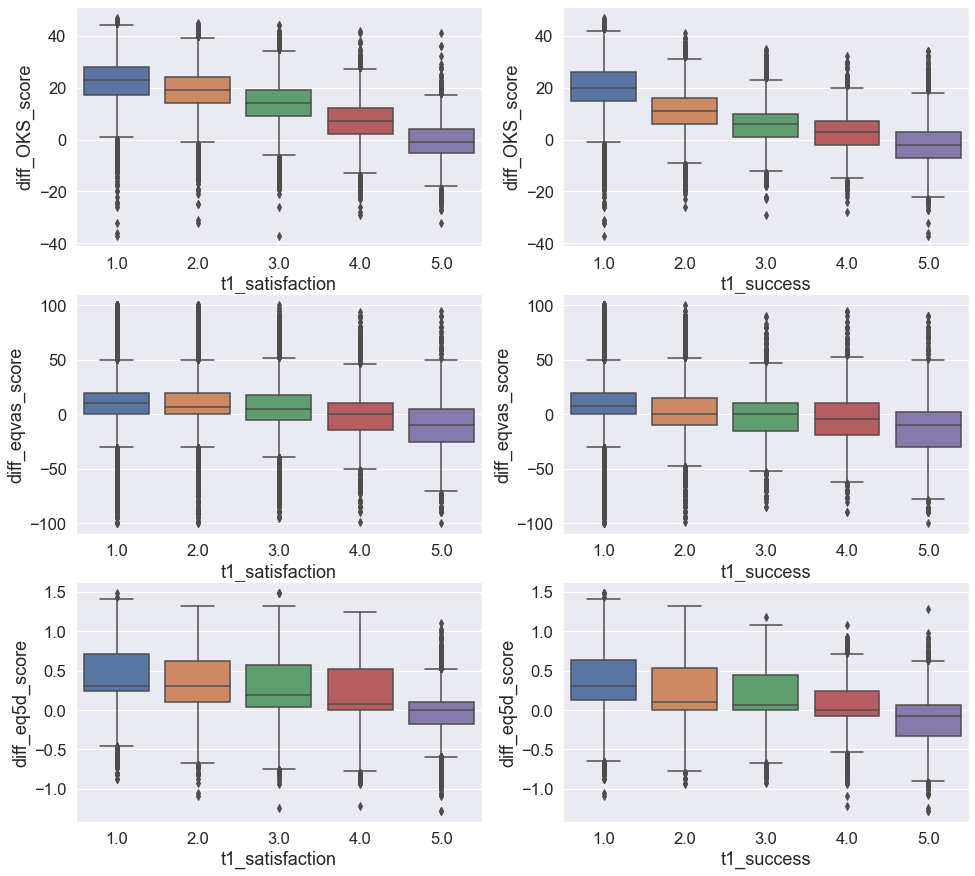

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))
ax =ax.flatten()
sns.boxplot(x=df_eda["t1_satisfaction"], y=df_eda["diff_OKS_score"], width=.8, ax=ax[0])
sns.boxplot(x=df_eda["t1_success"], y=df_eda["diff_OKS_score"], width=.8, ax=ax[1])
sns.boxplot(x=df_eda["t1_satisfaction"], y=df_eda["diff_eqvas_score"], width=.8, ax=ax[2])
sns.boxplot(x=df_eda["t1_success"], y=df_eda["diff_eqvas_score"], width=.8, ax=ax[3])
sns.boxplot(x=df_eda["t1_satisfaction"], y=df_eda["diff_eq5d_score"], width=.8, ax=ax[4])
sns.boxplot(x=df_eda["t1_success"], y=df_eda["diff_eq5d_score"], width=.8, ax=ax[5]);

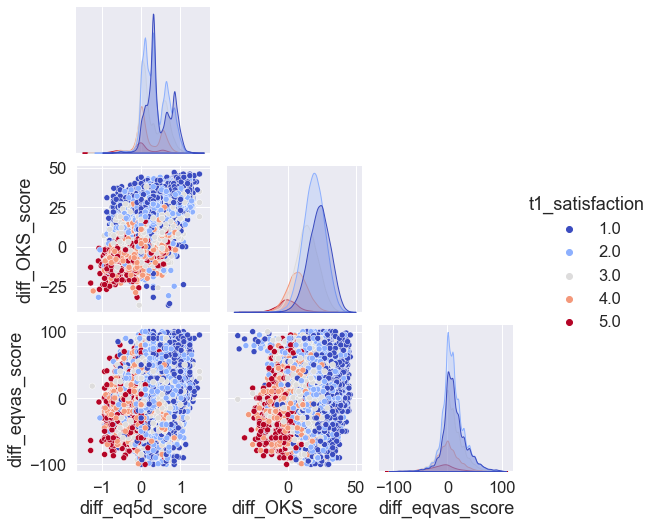

In [19]:
sns.pairplot(data=df_eda[['diff_eq5d_score','diff_OKS_score','diff_eqvas_score','t1_satisfaction']],hue='t1_satisfaction', palette="coolwarm", corner=True);

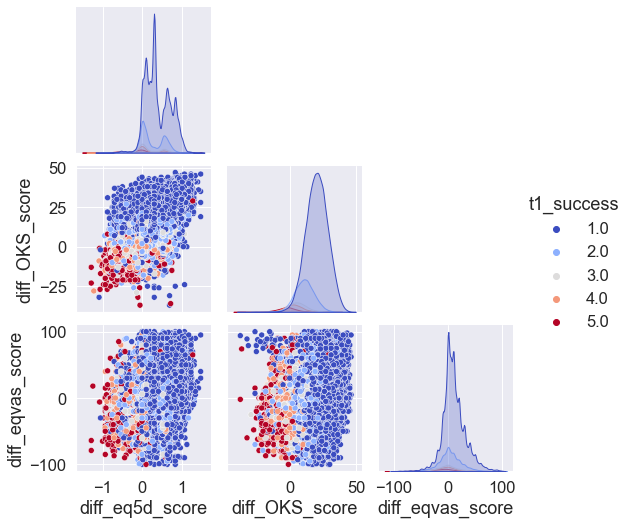

In [20]:
sns.pairplot(data=df_eda[['diff_eq5d_score','diff_OKS_score','diff_eqvas_score','t1_success']],hue='t1_success', palette="coolwarm", corner=True);

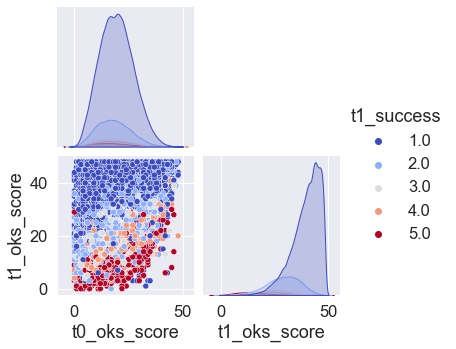

In [21]:
sns.pairplot(data=df_eda[['t0_oks_score','t1_oks_score','t1_success']], hue='t1_success', palette="coolwarm", corner=True);

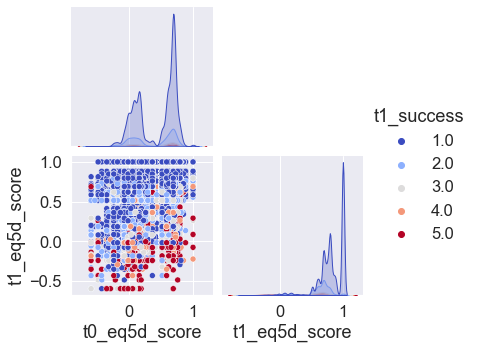

In [22]:
sns.pairplot(data=df_eda[['t0_eq5d_score','t1_eq5d_score','t1_success']], hue='t1_success', palette="coolwarm", corner=True);

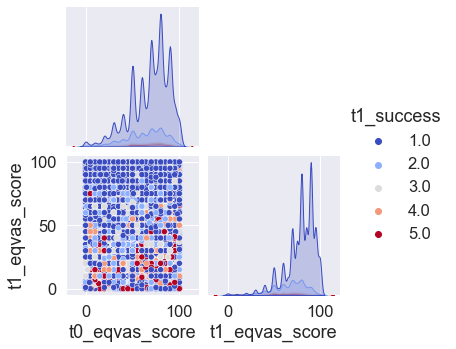

In [23]:
sns.pairplot(data=df_eda[['t0_eqvas_score','t1_eqvas_score','t1_success']], hue='t1_success', palette="coolwarm", corner=True);